In [0]:
!pip install git+https://github.com/fastai/fastai.git

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.imports import *
from sklearn.utils import shuffle
import imageio
from fastai.utils.mem import *


In [0]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/valid.txt')]

In [0]:
path_lbl = path/'labels'
path_img = path/'images'

In [0]:
URLs.CAMVID

'https://s3.amazonaws.com/fast-ai-imagelocal/camvid'

In [0]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/0001TP_006780.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_07800.png'),
 PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f01890.png')]

In [0]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/root/.fastai/data/camvid/labels/0016E5_08117_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f02490_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_00720_P.png')]

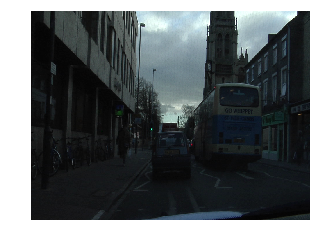

In [0]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'        

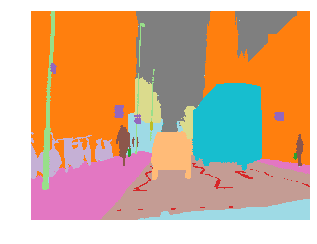

In [0]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [0]:
mask.data

tensor([[[21, 21, 21,  ..., 21, 21, 30],
         [21, 21, 21,  ..., 21, 21, 30],
         [21, 21, 21,  ..., 21, 21, 30],
         ...,
         [17, 17, 17,  ..., 17, 17, 17],
         [17, 17, 17,  ..., 17, 17, 17],
         [17, 17, 17,  ..., 17, 17, 17]]])

In [0]:
codes = np.loadtxt(path/'codes.txt', dtype=str)

In [0]:
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [0]:
src_size = np.array(mask.shape[1:])

In [0]:
size = src_size//2    #  720*960 //2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 11430MB of GPU RAM free


In [0]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')                       # Valid Data nicht random, da ansonsten fast gleiche Bilder im Valid-Set wären, da das Set aus einem Video stammt
       .label_from_func(get_y_fn, classes=codes))


In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)     #tfm_y=True damit bei der DataAugmentation auch die Maske mit verändert wird, wenn das Bild verändert wird
        .databunch(bs=bs)
        .normalize(imagenet_stats))

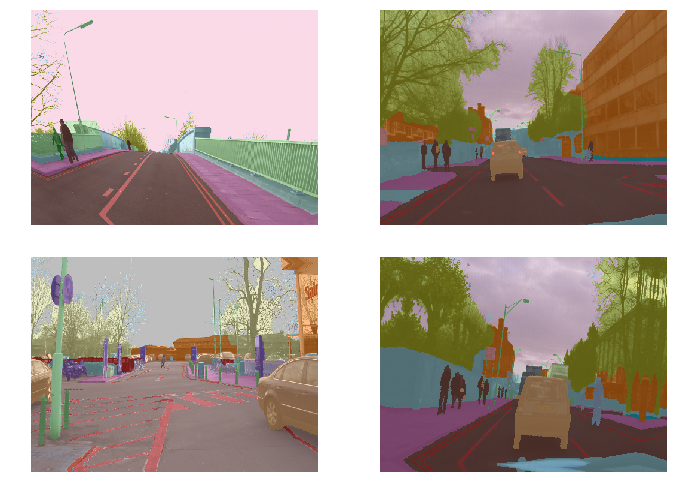

In [0]:
data.show_batch(2, figsize=(10,7))

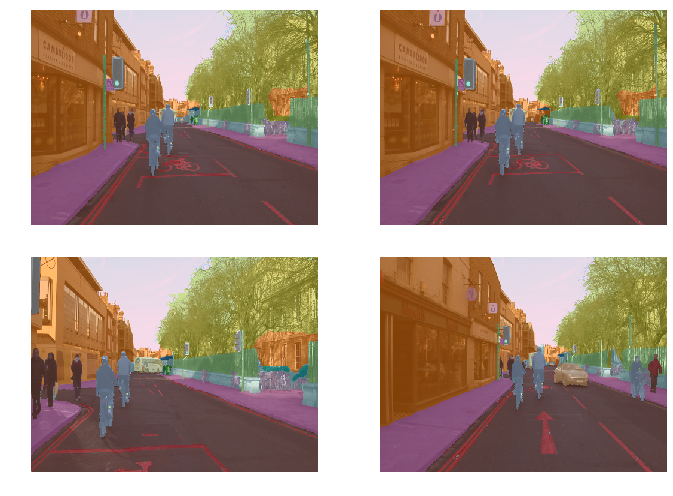

In [0]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

In [0]:
name2id['Tree']

26

In [0]:
def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()      # voidcode Pixel werden nicht mitbewertet

In [0]:
metrics = acc_camvid

In [0]:
learner = unet_learner(data, models.resnet34, metrics=metrics).to_fp16()

In [0]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


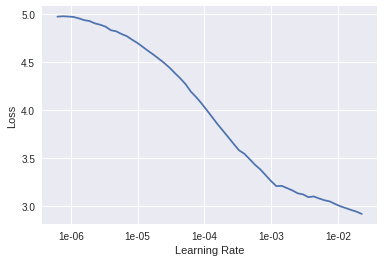

In [0]:
learner.recorder.plot()

In [0]:
learner.fit_one_cycle(10, pct_start=0.9) # pct_start=0.9 ---> Lernrate steigt über 90% der Epoche und fällt erst dann


epoch,train_loss,valid_loss,acc_camvid,time
0,1.412310,1.608321,0.528572,03:35
1,1.894123,1.528066,0.569988,03:24
2,1.422775,1.089517,0.719678,03:23
3,1.012675,0.794524,0.772666,03:23


In [0]:
learner.fit_one_cycle(4)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.729914,4.134599,0.347090,04:23
1,1.576466,1.332686,0.603916,03:28
2,1.142934,0.855911,0.768996,03:30
3,0.885172,0.729328,0.796954,03:28


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


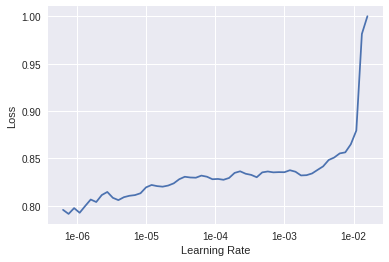

In [0]:
learner.lr_find()
learner.recorder.plot()